학습목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성분류 실습을 진행한다.

##  텍스트를 숫자로 표현하는 방법

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
# 우리가 가진 텍스트 데이터를 숫자로 바꿔보려고 하는데, 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스}구조여야 함.
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [8]:
# 이제 우리가 가진 텍스트 데이터를 숫자로 바꿔 표현해 봅시다.
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))
"""
<BOS> -> 1, i -> 3, eat -> 6, lunch -> 7
"""

[1, 3, 6, 7]


'\n<BOS> -> 1, i -> 3, eat -> 6, lunch -> 7\n'

In [9]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [10]:
# 반대로, encode된 벡터를 decode하여 다시 원래 텍스트 데이터로 복구할 수도 있습니다.
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [11]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


# embedding 레이어의 등장

In [12]:
# embedding 레이어를 활용하여 이전 스텝의 텍스트 데이터를 워드 벡터 텐서 형태로 다시 표현

# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다. 

import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있습니다.
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
output = embedding(raw_inputs)
print(output)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

위 코드를 실행하면 에러가 발생합니다. 이는 embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다. raw_inputs의 3개 벡터의 길이는 각각 4,4,5 입니다.

tensorflow에서는 keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.

In [13]:
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [16]:
# 위 코드를 실행하고 나서 다시 output=embedding(raw_inputs)을 실행

import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

"""
 shape=(3,5,4)에서 3은 입력 문장 개수, 5는 입력문장의 최대 길이, 4는 워드 벡터의 차원의 수
"""

tf.Tensor(
[[[-0.01011405 -0.01326608 -0.0182943  -0.02537967]
  [ 0.04415477  0.04008099 -0.04434595 -0.04613638]
  [-0.01381892  0.02739409 -0.04793549 -0.01694747]
  [-0.03792977 -0.01781761 -0.02282174 -0.02709488]
  [ 0.0304256   0.02521263 -0.02966472 -0.03759736]]

 [[-0.01011405 -0.01326608 -0.0182943  -0.02537967]
  [ 0.04415477  0.04008099 -0.04434595 -0.04613638]
  [ 0.04864373 -0.01861961  0.02289558  0.01804664]
  [-0.00638711 -0.02925316  0.04075861 -0.01692899]
  [ 0.0304256   0.02521263 -0.02966472 -0.03759736]]

 [[-0.01011405 -0.01326608 -0.0182943  -0.02537967]
  [ 0.03995342 -0.04976204 -0.01659255 -0.03087068]
  [ 0.04415477  0.04008099 -0.04434595 -0.04613638]
  [-0.01381892  0.02739409 -0.04793549 -0.01694747]
  [-0.02817357  0.03456438 -0.04853749  0.01931543]]], shape=(3, 5, 4), dtype=float32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


'\n shape=(3,5,4)에서 3은 입력 문장 개수, 5는 입력문장의 최대 길이, 4는 워드 벡터의 차원의 수\n'

# 시퀀스 데이터를 다루는 RNN
RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine으로 설계되었습니다. 이는 과거시점의 입력을 모두 저장하여 다음 시점으로 넘어가는 형태라, 각 시점의 입력들이 축척 됩니다.

In [17]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


# 꼭 RNN이어야 할까?
텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Nerual Network를 사용할 수도 있습니다. 이 모델은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을. 추출하여 그것으로 문장을 분류하는 방식. 또한 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있습니다.

In [18]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 있습니다. 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식.

In [19]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


# IMDB 영화리뷰 감성분석
긍정은 1, 부정은 0의 라벨이 달려있습니다. 50000개의 리뷰 중 절반인 25000개가 훈련용, 나머지가 테스트용.

In [20]:
# 데이터셋 분석
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.4.1
17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


`imdb.load_data()` 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 그 개수만큼의 `word_to_index` 딕셔너리까지 생성된 형태로 데이터셋이 생성됩니다.

In [21]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [22]:
# 이미 encode가 되어있습니다.
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


IMDb 데이터셋의 텍스트 인코딩을 위한 `word_to_index`, `index_to_word`는 아래와 같이 보정되어야 합니다. 아래 내용은 Tensorflow 튜토리얼의 가이드를 반영하여 작성하였습니다.
`word_to_index`는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어 있습니다.

In [23]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [24]:
# encode된 텍스트가 정상적으로 decode되는지 확인해 보겠습니다.
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [26]:
# pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일. maxlen의 값 설정도 전체 모델 성능에 영향을 미칩니다.
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [28]:
# padding 방식이 post인지 pre인지에 따라서 전체적인 성능 차이가 있습니다.
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

# pre가 훨씬 유리합니다.

(25000, 580)


# 모델 설계와 훈련

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 합니다. 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.

In [30]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [31]:
# model 학습을 시작해 봅시다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 6s 99ms/step - loss: 0.6929 - accuracy: 0.5110 - val_loss: 0.6906 - val_accuracy: 0.6015
Epoch 2/20
30/30 [==============================] - 1s 38ms/step - loss: 0.6846 - accuracy: 0.6270 - val_loss: 0.6646 - val_accuracy: 0.7163
Epoch 3/20
30/30 [==============================] - 1s 38ms/step - loss: 0.6239 - accuracy: 0.7923 - val_loss: 0.4556 - val_accuracy: 0.8296
Epoch 4/20
30/30 [==============================] - 1s 38ms/step - loss: 0.3651 - accuracy: 0.8705 - val_loss: 0.3233 - val_accuracy: 0.8617
Epoch 5/20
30/30 [==============================] - 1s 38ms/step - loss: 0.2089 - accuracy: 0.9199 - val_loss: 0.3018 - val_accuracy: 0.8777
Epoch 6/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1441 - accuracy: 0.9558 - val_loss: 0.3197 - val_accuracy: 0.8750
Epoch 7/20
30/30 [==============================] - 1s 38ms/step - loss: 0.0984 - accuracy: 0.9727 - val_loss: 0.3511 - val_accuracy: 0.8679
Epoch 8/20
30

In [32]:
# 학습이 끝난 모델을 테스트셋으로 평가해 봅니다.
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 3s - loss: 0.7519 - accuracy: 0.8421
[0.7519068121910095, 0.8421199917793274]


`model.fit()` 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있습니다.
이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


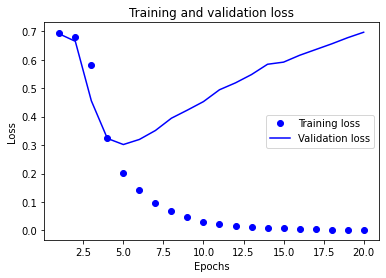

In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.

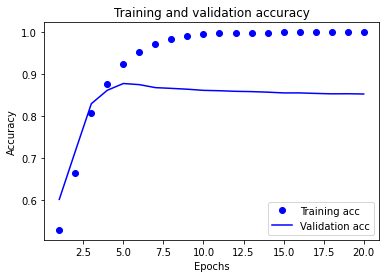

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Word2Vec의 적용
사용했던 model의 첫 번째 레이어는 바로 Embedding 레이어였습니다. 이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였습니다. 만약 우리의 감성분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것입니다.

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [36]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([ 0.0304888 ,  0.00653872,  0.02157151,  0.01217426, -0.04007436,
        0.00442104, -0.07201403,  0.01498448,  0.00517091,  0.0151215 ,
        0.02762864,  0.00631357, -0.00762655,  0.0195368 ,  0.0173985 ,
        0.01658303], dtype=float32)

 워드 벡터가 의미벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다.

In [38]:
word_vectors.similar_by_word("love")

[('decidedly', 0.848314642906189),
 ('realise', 0.8212144374847412),
 ('thrilled', 0.8202900290489197),
 ('marvellous', 0.8192571997642517),
 ('siblings', 0.8073940277099609),
 ('universe', 0.8056557178497314),
 ('farm', 0.8041637539863586),
 ('future', 0.8007098436355591),
 ('humor', 0.7980731725692749),
 ('bravery', 0.7944832444190979)]

우리가 다룬 정도의 훈련데이터로는 워드 벡터를 정교하게 학습시키기 어렵습니다.이번에는 구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 가져다 활용해 보겠습니다. Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었습니다. 

In [40]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

300dim의 벡터로 이루어진 300만 개의 단어입니다. 이 단어 사전을 메모리에 모두 로딩하면 아주 높은 확률로 여러분의 실습환경에 메모리 에러가 날 것입니다. 그래서 KeyedVectors.load_word2vec_format 메소드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩했습니다.

In [41]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.

In [42]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [43]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [44]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 14s 416ms/step - loss: 0.7057 - accuracy: 0.5031 - val_loss: 0.6917 - val_accuracy: 0.5190
Epoch 2/20
30/30 [==============================] - 11s 368ms/step - loss: 0.6821 - accuracy: 0.5598 - val_loss: 0.6759 - val_accuracy: 0.5862
Epoch 3/20
30/30 [==============================] - 11s 367ms/step - loss: 0.6517 - accuracy: 0.6504 - val_loss: 0.5993 - val_accuracy: 0.6975
Epoch 4/20
30/30 [==============================] - 11s 382ms/step - loss: 0.5163 - accuracy: 0.7848 - val_loss: 0.3773 - val_accuracy: 0.8396
Epoch 5/20
30/30 [==============================] - 11s 380ms/step - loss: 0.3092 - accuracy: 0.8782 - val_loss: 0.3110 - val_accuracy: 0.8684
Epoch 6/20
30/30 [==============================] - 11s 375ms/step - loss: 0.2242 - accuracy: 0.9157 - val_loss: 0.2980 - val_accuracy: 0.8758
Epoch 7/20
30/30 [==============================] - 11s 378ms/step - loss: 0.1697 - accuracy: 0.9411 - val_loss: 0.2928 - val_accuracy: 0.8789

In [45]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 7s - loss: 0.5145 - accuracy: 0.8651
[0.5145267248153687, 0.865119993686676]


# 프로젝트

순서)
1. 데이터 준비와 확인
2. 데이터로더 구성
3. 모델구성을 위한 데이터 분석 및 가공
4. 모델구성 및 validation set 구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석
8. 한국어 Word2Vec 임베딩 활용하여 성능개선

In [51]:
# 1.
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [61]:
# 2.
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [62]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [63]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [64]:
# 3.
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [65]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [66]:
X_test.shape

(49157, 41)

In [67]:
len(X_train)

146182

In [68]:
4. 
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


같은 파라미터로 3가지 모델을 학습
- 1-D CNN
- LSTM
- GlobalMaxPooling

In [72]:
# 1-D CNN
CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 256)         537856    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9       

In [73]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [74]:
# GlobalMaxPooling1D

GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [75]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [76]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results

----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 25s 89ms/step - loss: 0.6142 - accuracy: 0.6624 - val_loss: 0.4755 - val_accuracy: 0.8448
Epoch 2/20
247/247 [==============================] - 19s 77ms/step - loss: 0.3862 - accuracy: 0.8673 - val_loss: 0.3173 - val_accuracy: 0.8622
Epoch 3/20
247/247 [==============================] - 19s 75ms/step - loss: 0.2282 - accuracy: 0.9113 - val_loss: 0.3382 - val_accuracy: 0.8605
Epoch 4/20
247/247 [==============================] - 19s 75ms/step - loss: 0.1453 - accuracy: 0.9491 - val_loss: 0.4002 - val_accuracy: 0.8525
Epoch 5/20
247/247 [==============================] - 19s 75ms/step - loss: 0.0900 - accuracy: 0.9714 - val_loss: 0.4997 - val_accuracy: 0.8518
Epoch 6/20
247/247 [==============================] - 19s 75ms/step - loss: 0.0574 - accuracy: 0.9825 - val_loss: 0.6029 - val_accuracy: 0.8475
Epoch 7/20
247/247 [==============================] - 19s 76ms/step - los

247/247 [==============================] - 7s 28ms/step - loss: 0.0090 - accuracy: 0.9967 - val_loss: 0.7122 - val_accuracy: 0.8440
Epoch 16/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.7378 - val_accuracy: 0.8439
Epoch 17/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0075 - accuracy: 0.9968 - val_loss: 0.7571 - val_accuracy: 0.8447
Epoch 18/20
247/247 [==============================] - 7s 28ms/step - loss: 0.0071 - accuracy: 0.9969 - val_loss: 0.7777 - val_accuracy: 0.8439
Epoch 19/20
247/247 [==============================] - 7s 29ms/step - loss: 0.0063 - accuracy: 0.9973 - val_loss: 0.7989 - val_accuracy: 0.8438
Epoch 20/20
247/247 [==============================] - 7s 29ms/step - loss: 0.0065 - accuracy: 0.9973 - val_loss: 0.8138 - val_accuracy: 0.8438
Start evaluating GMP ...
1537/1537 - 2s - loss: 0.8232 - accuracy: 0.8410


In [77]:
# accuracy
for name, [_, acc] in sorted(model_result.items(), key=lambda x : x[1][1], reverse=True) :
    print(name,'\t',acc)

LSTM 	 0.8495839834213257
GMP 	 0.8410399556159973
CNN 	 0.8393514752388


3가지 모델중 LSTM이 가장 좋은 점수를 냈습니다.

In [80]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [81]:
word_vector_dim = 1000  # 워드 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model.add(keras.layers.LSTM(128, dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 이진분류


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/10
986/986 [==============================] - 75s 74ms/step - loss: 0.4570 - accuracy: 0.7762 - val_loss: 0.3400 - val_accuracy: 0.8537

Epoch 00001: val_accuracy improved from -inf to 0.85370, saving model to model.h5
Epoch 2/10
986/986 [==============================] - 72s 73ms/step - loss: 0.3088 - accuracy: 0.8676 - val_loss: 0.3178 - val_accuracy: 0.8639

Epoch 00002: val_accuracy improved from 0.85370 to 0.86390, saving model to model.h5
Epoch 3/10
986/986 [==============================] - 72s 73ms/step - loss: 0.2773 - accuracy: 0.8821 - val_loss: 0.3132 - val_accuracy: 0.8669

Epoch 00003: val_accuracy improved from 0.86390 to 0.86695, saving model to model.h5
Epoch 4/10
986/986 [==============================] - 71s 72ms/step - loss: 0.2472 - accuracy: 0.8960 - val_loss: 0.3138 - val_accuracy: 0.8669

Epoch 00004: val_accuracy did not improve from 0.86695
Epoch 5/10
986/986 [==============================] - 72s 73ms/step - loss: 0.2250 - accuracy: 0.9068 - val_loss:

In [82]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3407 - accuracy: 0.8624
[0.3406710624694824, 0.8623797297477722]


In [83]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


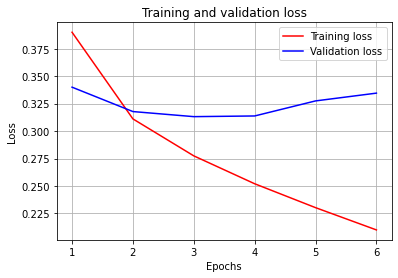

In [84]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

In [85]:
# 7.
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)


In [86]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [87]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['대박']
# vector

In [88]:
word_vectors.similar_by_word("대박")

[('최고', 0.5585905313491821),
 ('수준급', 0.5581956505775452),
 ('후딱', 0.5467694997787476),
 ('울컥', 0.5409130454063416),
 ('소장', 0.5390514135360718),
 ('탄탄', 0.5389233231544495),
 ('먹먹', 0.5387176275253296),
 ('담백', 0.5386830568313599),
 ('올려야', 0.5385977625846863),
 ('손색없', 0.5373140573501587)]

# 회고
https://github.com/tyshin94/MODULABS_AIFFEL-Course/blob/fa6d83986edec2e389f552559b453543ae0665ed/Mini%20Project/Sentiment%20classification/2020.09.01.%20Tue%20naver_movie_review.ipynb 의 코드를 참고해서 작성했습니다.

지금까지 아이펠의 교육과정은 대부분이 computer vision의 관련된 수업이었습니다. 그래서 아직은 nlp가 무척 어색하고 어렵습니다.... 그래서 제가 한 부분까지는 그래도 쪼오오오끔이나마 이해가 가능한데 한국어 word2vec은 당체 이해가 안되서 못했습니다. 별점도 항상 3개씩 받고는 싶지만, 아직 저는 평가를 받을수 있는 수준은 함참도 안되고 공부하고 배운다는 마음가짐으로 제가 이해한 부분만 올렸습니다. 제가 한 부분도 사실 참고한 코드를 복붙한 부분이 대부분이라 제가 한 작업이라고 하기도 힘들긴 하지만요. 변명아닌 변명을 하자면.... 노드가 밀려있어서 exploration 노드를 끝내기도 힘든데 밀린 노드까지 하려고 하니 시간이 많이 부족하고 체력적인 한계에 여기까지 했습니다.. 죄송합니다... 다음에는 루브릭의 조건을 다 충족할 수 있게 더 노력하겠습니다!
